# Overview

The following notebook serves the purpose of addressing some of the queries listed in this [link](https://docs.google.com/document/d/1-3q0Ow_a5IzsrWm7k1hc3YmIzoW_k7Xyf40Qp4wICAI/edit#heading=h.z3syrddb94ke) Here we perform EDA on insight operator workload dataset.

# DATA COLLECTION AND PRE-PROCESSING

In [172]:
import io
import boto3
import pandas as pd
import warnings
import os
import seaborn as sns

import matplotlib.pyplot as plt

from dotenv import load_dotenv, find_dotenv

In [173]:
load_dotenv(find_dotenv())
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [174]:
# CEPH Bucket variables
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")

# s3 resource to communicate with storage
s3 = boto3.resource(
    "s3",
    endpoint_url=s3_endpoint_url,
    aws_access_key_id=s3_access_key,
    aws_secret_access_key=s3_secret_key,
)

# access the parquet file as an s3 object

obj1 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/date=2021-05-12/2021-05-12.parquet"
)
obj2 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/containers/date=2021-05-12/2021-05-12.parquet"
)
obj3 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/dataframe_image_id.parquet"
)
obj4 = s3.Object("DH-PLAYPEN", "ccx/fingerprinting/containers/df_cont_image_id.parquet")
obj5 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/telemeter_image_data.parquet"
)
obj6 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/containers/telemeter_cont_data.parquet"
)

obj7 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/df_image_layerid.parquet"
)
# download the file into the buffer
buffer1 = io.BytesIO()
obj1.download_fileobj(buffer1)
buffer2 = io.BytesIO()
obj2.download_fileobj(buffer2)
buffer3 = io.BytesIO()
obj3.download_fileobj(buffer3)
buffer4 = io.BytesIO()
obj4.download_fileobj(buffer4)
buffer5 = io.BytesIO()
obj5.download_fileobj(buffer5)
buffer6 = io.BytesIO()
obj6.download_fileobj(buffer6)
buffer7 = io.BytesIO()
obj7.download_fileobj(buffer7)

# read the buffer and create the dataframe
image_layers_df = pd.read_parquet(buffer1)
image_id_map = pd.read_parquet(buffer3)
image_layer_idmap = pd.read_parquet(buffer7)
containers_df = pd.read_parquet(buffer2)
cont_id_map = pd.read_parquet(buffer4)
telemeter_image_data = pd.read_parquet(buffer5)
telemeter_cont_data = pd.read_parquet(buffer6)

We now have the six sets of dataframes,

- Image layer dataset (_**image_layers_df**_)
- Image name mapping for sha's of image_id from image layer dataset (_**image_id_mapping**_)
- Image layer id mapping for sha's of the layers of the corresponding image_id (**image_layer_idmap**)
- Containers dataset (_**containers_df**_)
- Image name mapping for sha's of the image_id from container dataset (_**cont_imageid_map**_)
- Information from the telemeter for the corresponding cluster_id from image_layers_dataset (_**telemeter_image_data**_)
- Information from the telemeter for the corresponding cluster_id from container dataset (_**telemeter_cont_data**_)

## IMAGE LAYER DATASET

The dataset which gives information about the images. 

In [175]:
image_layers_df.head(2)

,cluster_id,image_id,layer_image_id,layer_image_level,first_command,first_arg,archive_path
0,00003d61-9db1-4757-9cd1-84df271daeb9,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,sha256:9ebb302e1fb002fb643091710dac46f8258781d...,0,icTsn2s_EIax,2v1NneeWoS_9,archives/compressed/00/00003d61-9db1-4757-9cd1...
1,00003d61-9db1-4757-9cd1-84df271daeb9,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,sha256:a74396a32e85c2feeedf76052ed3297859810c8...,1,icTsn2s_EIax,2v1NneeWoS_9,archives/compressed/00/00003d61-9db1-4757-9cd1...


**Pyxis data for the image SHA’s in IMAGE_ID column of image_layers dataset** [Pyxis mapping notebook](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/blob/master/notebooks/pyxis_mapping.ipynb), [Issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/11#issuecomment-867776402)

In [176]:
image_id_map = image_id_map.reset_index()
image_id_map.head(2)

,image_id,License,architecture,build-date,com.redhat.build-host,com.redhat.component,com.redhat.license_terms,description,distribution-scope,io.k8s.description,io.k8s.display-name,io.openshift.build.commit.id,io.openshift.build.commit.url,io.openshift.build.source-location,io.openshift.expose-services,io.openshift.maintainer.component,io.openshift.maintainer.product,io.openshift.tags,maintainer,name,release,summary,url,vcs-ref,vcs-type,vendor,version,io.openshift.s2i.scripts-url,io.s2i.scripts-url,usage,io.openshift.s2i.assemble-user,authoritative-source-url,io.fabric8.s2i.version.jolokia,org.concrt.version,org.jboss.product,org.jboss.product.amq.version,org.jboss.product.openjdk.version,org.jboss.product.version,com.redhat.deployments-dir,com.redhat.dev-mode,io.jenkins.version
0,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,GPLv2+,x86_64,2021-04-30T00:31:42.349887,cpt-1004.osbs.prod.upshift.rdu2.redhat.com,ose-cli-artifacts-container,https://www.redhat.com/agreements,"OpenShift is a platform for developing, buildi...",public,"OpenShift is a platform for developing, buildi...",OpenShift Clients,a765590e1b87b014b9d81f9ea534460d6dff73f2,https://github.com/openshift/oc/commit/a765590...,https://github.com/openshift/oc,,oc,OpenShift Container Platform,"openshift,cli","Red Hat, Inc.",openshift/ose-cli-artifacts,202104292348.p0,Provides the latest release of Red Hat Univers...,https://access.redhat.com/containers/#/registr...,43f412b2932a5ecfe5ebedcab38cf2915cf03813,git,"Red Hat, Inc.",v4.8.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,sha256:3574d6c1fcc46e1ebd41b7b887b92035ea18213...,GPLv2+,x86_64,2021-04-30T00:22:29.539443,cpt-1008.osbs.prod.upshift.rdu2.redhat.com,openshift-enterprise-cli-container,https://www.redhat.com/agreements,"OpenShift is a platform for developing, buildi...",public,"OpenShift is a platform for developing, buildi...",OpenShift Client,a765590e1b87b014b9d81f9ea534460d6dff73f2,https://github.com/openshift/oc/commit/a765590...,https://github.com/openshift/oc,,oc,OpenShift Container Platform,"openshift,cli","Red Hat, Inc.",openshift/ose-cli,202104292348.p0,Provides the latest release of Red Hat Univers...,https://access.redhat.com/containers/#/registr...,d3ae20f4e2fac18ea671cf12636d16791146a460,git,"Red Hat, Inc.",v4.8.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None


**Pyxis data for SHA’s in IMAGE_LAYER_ID column of image_layers dataset**

In [177]:
image_layer_idmap = image_layer_idmap.reset_index()
image_layer_idmap = image_layer_idmap.rename(columns={"image_id": "layer_image_id"})
image_layer_idmap.head(2)

,layer_image_id,architecture,build-date,com.redhat.build-host,com.redhat.component,com.redhat.license_terms,description,distribution-scope,io.k8s.description,io.k8s.display-name,io.openshift.expose-services,io.openshift.tags,maintainer,name,release,summary,url,vcs-ref,vcs-type,vendor,version,io.openshift.s2i.scripts-url,io.s2i.scripts-url,com.redhat.deployments-dir,com.redhat.dev-mode,com.redhat.dev-mode.port,help,usage,io.openshift.s2i.assemble-user,authoritative-source-url,License,Architecture,Authoritative_Registry,BZComponent,Build_Host,Name,Release,Vendor,Version,com.ibm.hdm.common.branch,com.ibm.hdm.common.buildnumber,com.ibm.hdm.common.commitId,org.label-schema.vcs-ref,org.label-schema.vcs-url,io.openshift.build.commit.id,io.openshift.build.commit.url,io.openshift.build.source-location,io.openshift.maintainer.product,io.openshift.maintainer.component,io.cekit.version,io.fabric8.s2i.version.jolokia,io.fabric8.s2i.version.maven,io.openshift.s2i.destination,org.jboss.container.deployments-dir,org.jboss.product,org.jboss.product.openjdk.version,org.jboss.product.version,org.concrt.version,org.jboss.product.amq.version,com.ibm.license_terms,org.label-schema.build-date,org.label-schema.license,org.label-schema.name,org.label-schema.schema-version,org.label-schema.vendor,io.fabric8.s2i.version.karaf,io.fabric8.s2i.version.prometheus.jmx_exporter,org.jboss.deployments-dir,org.jboss.product.eap.version
0,sha256:fdb393d8227cbe9756537d3f215a3098ae797bd...,x86_64,2021-02-10T00:15:26.710361,cpt-1004.osbs.prod.upshift.rdu2.redhat.com,ubi8-container,https://www.redhat.com/en/about/red-hat-end-us...,The Universal Base Image is designed and engin...,public,The Universal Base Image is designed and engin...,Red Hat Universal Base Image 8,,base rhel8,"Red Hat, Inc.",ubi8,289,Provides the latest release of Red Hat Univers...,https://access.redhat.com/containers/#/registr...,7dd0869dabeebe7119fc04b16767c5991bcaa865,git,"Red Hat, Inc.",8.3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,sha256:64607cc74f9cbe0e12f167547df0cf661de5a8b...,x86_64,2021-03-30T18:30:01.465792,cpt-1003.osbs.prod.upshift.rdu2.redhat.com,ubi8-container,https://www.redhat.com/en/about/red-hat-end-us...,The Universal Base Image is designed and engin...,public,The Universal Base Image is designed and engin...,Red Hat Universal Base Image 8,,base rhel8,"Red Hat, Inc.",ubi8,297,Provides the latest release of Red Hat Univers...,https://access.redhat.com/containers/#/registr...,7dd0869dabeebe7119fc04b16767c5991bcaa865,git,"Red Hat, Inc.",8.3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


**Telemetry dataset for the corresponding `CLUSTER_ID` from image_layers dataset**

In [178]:
telemeter_image_data.rename(columns={"_id": "cluster_id"}, inplace=True)
telemeter_image_data.head(2)

,cluster_id,timestamp,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum,value_openshift:cpu_usage_cores:sum,value_openshift:memory_usage_bytes:sum,value_cluster:cpu_usage_cores:sum,value_cluster:memory_usage_bytes:sum
0,00003d61-9db1-4757-9cd1-84df271daeb9,1620860062,0.03230751556666692,389971968,1.9291393691359602,14560608256,1.9614468847026272,14950580224
1,00351e6e-53ce-465e-9493-cf0cd2367049,1620852056,0.030943035959259964,385421312,1.7056283926121354,14386823168,1.7365714285713953,14772244480


## **Containers Dataset**

The datasets containing the information about the images running in the containers. 

In [179]:
containers_df.head(2)

,cluster_id,namespace,shape,shape_instances,image_id,first_command,first_arg,init_container,archive_path
0,00003d61-9db1-4757-9cd1-84df271daeb9,0LiT6ZNtbpYL,sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...,1,sha256:f46f210d6023bec16e68340b484a8881ce46d5e...,None,47DEQpj8HBSa,False,archives/compressed/00/00003d61-9db1-4757-9cd1...
1,00003d61-9db1-4757-9cd1-84df271daeb9,0LiT6ZNtbpYL,sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...,1,sha256:edb9aaacf421c6dc45b20324e8699cec02f26bf...,n9CdwzVF-cwZ,RNOaw_AuQeIY,False,archives/compressed/00/00003d61-9db1-4757-9cd1...


**Pyxis data for the image SHA’s in IMAGE_ID column of container dataset**

In [180]:
cont_id_map = cont_id_map.reset_index()
cont_id_map.head(2)

,image_id,License,architecture,build-date,com.redhat.build-host,com.redhat.component,com.redhat.license_terms,description,distribution-scope,io.k8s.description,io.k8s.display-name,io.openshift.build.commit.id,io.openshift.build.commit.url,io.openshift.build.source-location,io.openshift.expose-services,io.openshift.maintainer.component,io.openshift.maintainer.product,io.openshift.tags,maintainer,name,release,summary,url,vcs-ref,vcs-type,vendor,version,io.openshift.maintainer.subcomponent,io.openshift.release.operator,io.openshift.build.versions,com.redhat.delivery.appregistry,upstream-vcs-ref,upstream-vcs-type,upstream-version,org.kubevirt.hco.csv-generator.v1,io.openshift.s2i.scripts-url,io.s2i.scripts-url,usage,io.openshift.s2i.assemble-user,display-name,com.redhat.delivery.operator.bundle,com.redhat.openshift.versions,io.cekit.version,operators.operatorframework.io.bundle.channel.default.v1,operators.operatorframework.io.bundle.channels.v1,operators.operatorframework.io.bundle.manifests.v1,operators.operatorframework.io.bundle.mediatype.v1,operators.operatorframework.io.bundle.metadata.v1,operators.operatorframework.io.bundle.package.v1,licenses,CEPH_POINT_RELEASE,GIT_BRANCH,GIT_CLEAN,GIT_COMMIT,GIT_REPO,RELEASE,ocs.tags,com.redhat.deployments-dir,com.redhat.dev-mode,com.redhat.dev-mode.port,help,operators.operatorframework.io.index.database.v1,authoritative-source-url,license,io.fabric8.s2i.version.jolokia,io.fabric8.s2i.version.maven,io.openshift.s2i.destination,org.jboss.container.deployments-dir,org.jboss.product,org.jboss.product.eap.version,org.jboss.product.openjdk.version,org.jboss.product.sso.version,org.jboss.product.version,istio_version,openshift_build,operator_build,run,org.concrt.version,org.jboss.product.amq.version,io.openshift.build.commit.author,io.openshift.build.commit.date,io.openshift.build.commit.message,io.openshift.build.commit.ref,io.openshift.build.name,io.openshift.build.namespace,io.openshift.build.source-context-dir,jenkins.build.number,jenkins.tarball.url,io.jenkins.version,build-utility,org.label-schema.vcs-ref,org.label-schema.vcs-url,org.label-schema.description,org.label-schema.license,org.label-schema.name,org.label-schema.schema-version,org.label-schema.vendor,JAVA_VERSION,com.ibm.events.commitid,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.commitid,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.job,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.license,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.maintainer,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.name,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.version,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.commitid,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.job,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.license,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.maintainer,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.name,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.version,com.redhat.apb.runtime,com.microsoft.product,com.microsoft.version
0,sha256:f46f210d6023bec16e68340b484a8881ce46d5e...,ASL 2.0,x86_64,2021-05-04T21:54:58.392948,cpt-1007.osbs.prod.upshift.rdu2.redhat.com,kube-rbac-proxy-container,https://www.redhat.com/agreements,"This is a proxy, that can perform Kubernetes R...",public,"This is a proxy, that can perform Kubernetes R...",kube-rbac-proxy,8d11a8fa9ce252cd25794c0d9280cbdc0c2affcb,https://github.com/openshift/kube-rbac-proxy/c...,https://github.com/openshift/kube-rbac-proxy,,Monitoring,OpenShift Container Platform,kubernetes,OpenShift Monitoring Team <team-monitoring@red...,openshift/ose-kube-rbac-proxy,202105042126.p0,,https://access.redhat.com/containers/#/registr...,12ef9d3cc226f6bd4a898d4b23ffa1ec5d3d27f1,git,"Red Hat, Inc.",v4.8.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Non

**Telemetry dataset for the corresponding `CLUSTER_ID` from containers dataset**

In [181]:
telemeter_cont_data.rename(columns={"_id": "cluster_id"}, inplace=True)
telemeter_cont_data.head(2)

,cluster_id,timestamp,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum,value_openshift:cpu_usage_cores:sum,value_openshift:memory_usage_bytes:sum,value_cluster:cpu_usage_cores:sum,value_cluster:memory_usage_bytes:sum
0,00003d61-9db1-4757-9cd1-84df271daeb9,1620860062,0.03230751556666692,389971968,1.9291393691359602,14560608256,1.9614468847026272,14950580224
1,00351e6e-53ce-465e-9493-cf0cd2367049,1620852056,0.030943035959259964,385421312,1.7056283926121354,14386823168,1.7365714285713953,14772244480


Using the mapping techniques from the [issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/14), we were able to map most (not all) of the image_id from the image layers dataset and containers datasets. Information from the telemetry dataset were also extracted ([issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/15)). In the next steps, we try to merge the respective dataset with respect to the `image_id` and `cluster_id`.

# Merging the datasets 

We do the `outer` merging in-order to keep all the information including those ids which were not mapped and those for which we could not extract any information from the telemeter dataset.

**Merged dataframe for image layers dataset**

We will be merging the workload dataset with Pyxis data on `image_id` column, and merging with the telemeter data on `cluster_id` column.

In [182]:
df_image1 = pd.merge(image_layers_df, image_id_map, on="image_id", how="outer")
df_image = pd.merge(df_image1, telemeter_image_data, on="cluster_id", how="outer")
df_image.head(5)

,cluster_id,image_id,layer_image_id,layer_image_level,first_command,first_arg,archive_path,License,architecture,build-date,com.redhat.build-host,com.redhat.component,com.redhat.license_terms,description,distribution-scope,io.k8s.description,io.k8s.display-name,io.openshift.build.commit.id,io.openshift.build.commit.url,io.openshift.build.source-location,io.openshift.expose-services,io.openshift.maintainer.component,io.openshift.maintainer.product,io.openshift.tags,maintainer,name,release,summary,url,vcs-ref,vcs-type,vendor,version,io.openshift.s2i.scripts-url,io.s2i.scripts-url,usage,io.openshift.s2i.assemble-user,authoritative-source-url,io.fabric8.s2i.version.jolokia,org.concrt.version,org.jboss.product,org.jboss.product.amq.version,org.jboss.product.openjdk.version,org.jboss.product.version,com.redhat.deployments-dir,com.redhat.dev-mode,io.jenkins.version,timestamp,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum,value_openshift:cpu_usage_cores:sum,value_openshift:memory_usage_bytes:sum,value_cluster:cpu_usage_cores:sum,value_cluster:memory_usage_bytes:sum
0,00003d61-9db1-4757-9cd1-84df271daeb9,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,sha256:9ebb302e1fb002fb643091710dac46f8258781d...,0,icTsn2s_EIax,2v1NneeWoS_9,archives/compressed/00/00003d61-9db1-4757-9cd1...,GPLv2+,x86_64,2021-04-30T00:31:42.349887,cpt-1004.osbs.prod.upshift.rdu2.redhat.com,ose-cli-artifacts-container,https://www.redhat.com/agreements,"OpenShift is a platform for developing, buildi...",public,"OpenShift is a platform for developing, buildi...",OpenShift Clients,a765590e1b87b014b9d81f9ea534460d6dff73f2,https://github.com/openshift/oc/commit/a765590...,https://github.com/openshift/oc,,oc,OpenShift Container Platform,"openshift,cli","Red Hat, Inc.",openshift/ose-cli-artifacts,202104292348.p0,Provides the latest release of Red Hat Univers...,https://access.redhat.com/containers/#/registr...,43f412b2932a5ecfe5ebedcab38cf2915cf03813,git,"Red Hat, Inc.",v4.8.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.620860e+09,0.03230751556666692,389971968,1.9291393691359602,14560608256,1.9614468847026272,14950580224
1,00003d61-9db1-4757-9cd1-84df271daeb9,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,sha256:a74396a32e85c2feeedf76052ed3297859810c8...,1,icTsn2s_EIax,2v1NneeWoS_9,archives/compressed/00/00003d61-9db1-4757-9cd1...,GPLv2+,x86_64,2021-04-30T00:31:42.349887,cpt-1004.osbs.prod.upshift.rdu2.redhat.com,ose-cli-artifacts-container,https://www.redhat.com/agreements,"OpenShift is a platform for developing, buildi...",public,"OpenShift is a platform for developing, buildi...",OpenShift Clients,a765590e1b87b014b9d81f9ea534460d6dff73f2,https://github.com/openshift/oc/commit/a765590...,https://github.com/openshift/oc,,oc,OpenShift Container Platform,"openshift,cli","Red Hat, Inc.",openshift/ose-cli-artifacts,202104292348.p0,Provides the latest release of Red Hat Univers...,https://access.redhat.com/containers/#/registr...,43f412b2932a5ecfe5ebedcab38cf2915cf03813,git,"Red Hat, Inc.",v4.8.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.620860e+09,0.03230751556666692,389971968,1.9291393691359602,14560608256,1.9614468847026272,14950580224
2,00003d61-9db1-4757-9cd1-84df271daeb9,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,sha256:7db62383a7470afbacfc0fab55d5a182e3c5fa2...,2,icTsn2s_EIax,2v1NneeWoS_9,archives/compressed/00/00003d61-9db1-4757-9cd1...,GPLv2+,x86_64,2021-04-30T00:31:42.349887,cpt-1004.osbs.prod.upshift.rdu2.redhat.com,ose-cli-artifacts-container,https://www.redhat.com/agreements,"OpenShift is a platform for developing, buildi...",public,"OpenShift is a platform for developing, buildi...",OpenShift Clients,a765590e1b87b014b9d81f9ea534460d6dff73f2,https://github.com/openshift/oc/commit/a765590...,https://github.com/openshift/oc,,oc,OpenShift Container Platform,"openshift,cli","Red Hat, Inc.",openshift/ose-cli-artifacts,202104292348.p0,Provides the latest release of Red Hat Univ

**Merged dataframe for containers dataset**

In [183]:
df_cont1 = pd.merge(containers_df, cont_id_map, on="image_id", how="outer")
df_cont = pd.merge(df_cont1, telemeter_image_data, on="cluster_id", how="outer")
df_cont.head(5)

,cluster_id,namespace,shape,shape_instances,image_id,first_command,first_arg,init_container,archive_path,License,architecture,build-date,com.redhat.build-host,com.redhat.component,com.redhat.license_terms,description,distribution-scope,io.k8s.description,io.k8s.display-name,io.openshift.build.commit.id,io.openshift.build.commit.url,io.openshift.build.source-location,io.openshift.expose-services,io.openshift.maintainer.component,io.openshift.maintainer.product,io.openshift.tags,maintainer,name,release,summary,url,vcs-ref,vcs-type,vendor,version,io.openshift.maintainer.subcomponent,io.openshift.release.operator,io.openshift.build.versions,com.redhat.delivery.appregistry,upstream-vcs-ref,upstream-vcs-type,upstream-version,org.kubevirt.hco.csv-generator.v1,io.openshift.s2i.scripts-url,io.s2i.scripts-url,usage,io.openshift.s2i.assemble-user,display-name,com.redhat.delivery.operator.bundle,com.redhat.openshift.versions,io.cekit.version,operators.operatorframework.io.bundle.channel.default.v1,operators.operatorframework.io.bundle.channels.v1,operators.operatorframework.io.bundle.manifests.v1,operators.operatorframework.io.bundle.mediatype.v1,operators.operatorframework.io.bundle.metadata.v1,operators.operatorframework.io.bundle.package.v1,licenses,CEPH_POINT_RELEASE,GIT_BRANCH,GIT_CLEAN,GIT_COMMIT,GIT_REPO,RELEASE,ocs.tags,com.redhat.deployments-dir,com.redhat.dev-mode,com.redhat.dev-mode.port,help,operators.operatorframework.io.index.database.v1,authoritative-source-url,license,io.fabric8.s2i.version.jolokia,io.fabric8.s2i.version.maven,io.openshift.s2i.destination,org.jboss.container.deployments-dir,org.jboss.product,org.jboss.product.eap.version,org.jboss.product.openjdk.version,org.jboss.product.sso.version,org.jboss.product.version,istio_version,openshift_build,operator_build,run,org.concrt.version,org.jboss.product.amq.version,io.openshift.build.commit.author,io.openshift.build.commit.date,io.openshift.build.commit.message,io.openshift.build.commit.ref,io.openshift.build.name,io.openshift.build.namespace,io.openshift.build.source-context-dir,jenkins.build.number,jenkins.tarball.url,io.jenkins.version,build-utility,org.label-schema.vcs-ref,org.label-schema.vcs-url,org.label-schema.description,org.label-schema.license,org.label-schema.name,org.label-schema.schema-version,org.label-schema.vendor,JAVA_VERSION,com.ibm.events.commitid,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.commitid,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.job,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.license,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.maintainer,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.name,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.version,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.commitid,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.job,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.license,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.maintainer,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.name,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.version,com.redhat.apb.runtime,com.microsoft.product,com.microsoft.version,timestamp,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum,value_openshift:cpu_usage_cores:sum,value_openshift:memory_usage_bytes:sum,value_cluster:cpu_usage_cores:sum,value_cluster:memory_usage_bytes:sum
0,00003d61-9db1-4757-9cd1-84df271daeb9,0LiT6ZNtbpYL,sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...,1,sha256:f46f210d6023bec16e68340b484a8881ce46d5e...,None,47DEQpj8HBSa,False,archives/compressed/00/00003d61-9db1-4757-9cd1...,ASL 2.0,x86_64,2021-05-04T21:54:58.392948,cpt-1007.osbs.prod.upshift.rdu2.redhat.com,kube-rbac-proxy-container,https://www.redhat.com/agreements,"This is a proxy, that can perform Kubernetes R...",public,"This is a proxy, that can perform Kubernetes R...",kube-rbac-proxy,8d11a8fa9ce252cd25794c0d9280cbdc0c2a

---

# Image layers dataset

Here is the list of all the features in the image_layers dataset.

In [13]:
df_image.iloc[:1, :].T

,0
cluster_id,00003d61-9db1-4757-9cd1-84df271daeb9
image_id,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...
layer_image_id,sha256:9ebb302e1fb002fb643091710dac46f8258781d...
layer_image_level,0
first_command,icTsn2s_EIax
first_arg,2v1NneeWoS_9
archive_path,archives/compressed/00/00003d61-9db1-4757-9cd1...
License,GPLv2+
architecture,x86_64
build-date,2021-04-30T00:31:42.349887


# Containers dataset

Here is the list of all the features from the container dataset.

In [14]:
df_cont.iloc[:1, :].T

,0
cluster_id,00003d61-9db1-4757-9cd1-84df271daeb9
namespace,0LiT6ZNtbpYL
shape,sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...
shape_instances,1
image_id,sha256:f46f210d6023bec16e68340b484a8881ce46d5e...
first_command,None
first_arg,47DEQpj8HBSa
init_container,False
archive_path,archives/compressed/00/00003d61-9db1-4757-9cd1...
License,ASL 2.0


# Some FAQs

## How many images are rhel7, rhel8, and ubi8 based?

For the image layer dataset, the list of unique image repo name are listed below.

In [15]:
image_repos = df_image.name.unique()
image_repos = map(str, image_repos)
image_repos = list(image_repos)

In [16]:
print(
    "Total number of image_repos in image_layer dataset is {n}".format(
        n=len(image_repos)
    )
)

Total number of image_repos in image_layer dataset is 26


**Number of image_repos based on rhel7, rhel8, and ubi8 in image_layers_dataset**

In [17]:
repo = ["rhel7", "rhel8", "ubi8"]
total = 0
for rep in repo:
    res = [i for i in image_repos if rep in i]
    print(
        "The number of images based on {rep} in the image_layer_dataset is {len_res}".format(
            rep=rep, len_res=len(res)
        )
    )
    total += len(res)
print(
    "The number of images based on others in image_layers_dataset is {total}".format(
        total=len(image_repos) - total
    )
)

The number of images based on rhel7 in the image_layer_dataset is 8
The number of images based on rhel8 in the image_layer_dataset is 6
The number of images based on ubi8 in the image_layer_dataset is 2
The number of images based on others in image_layers_dataset is 10


For containers dataset, the list of unique image repo name are listed below.

In [18]:
cont_repos = df_cont.name.unique()
cont_repos = map(str, cont_repos)
cont_repos = list(cont_repos)

In [19]:
print(
    "Total number of cont_repos in containers dataset is {n}".format(n=len(cont_repos))
)

Total number of cont_repos in containers dataset is 354


**Number of image_repos based on rhel7, rhel8, and ubi8 in containers dataset**

In [20]:
repo = ["rhel7", "rhel8", "ubi8"]
total = 0
for rep in repo:
    res = [i for i in cont_repos if rep in i]
    print(
        "The number of images based on {rep} in the containers_dataset is {len_res}".format(
            rep=rep, len_res=len(res)
        )
    )
    total += len(res)
print(
    "The number of images based on others in containers_dataset is {total}".format(
        total=len(cont_repos) - total
    )
)

The number of images based on rhel7 in the containers_dataset is 20
The number of images based on rhel8 in the containers_dataset is 123
The number of images based on ubi8 in the containers_dataset is 4
The number of images based on others in containers_dataset is 207


---

## How many mysql images are we seeing that are published on dockerhub (input is set of SHAs from docker)?

To address this query, we filter our dataframe based on the `url` information from the dataset. After filtering, we try to find the image_repo corresponding to mysql. 

**Image layer Dataset** 

In [188]:
df = df_image[["name", "url"]]
df = df[df.url.notnull()]
df = df[df.url.str.contains("docker")]  # filtering url containing name docker
df.head()

,name,url


In [184]:
df = df_cont[["name", "url"]]
df = df[df.url.notnull()]
df = df[df.url.str.contains("docker")]  # filtering url containing name docker
df.head()

In [187]:
df.name.unique()

array(['openshift/ose-docker-registry', 'openshift/ose-docker-builder'],
      dtype=object)

---

## How many redis/mysql command hashes are we seeing?

Filtering the dataframe with respect to sql image repos and counting the corresponding commands later. 

In [66]:
df = df_image[["name", "first_command"]]
df = df[df.name.notnull()]
df["first_command"].fillna("not identified", inplace=True)
df = df[df.name.str.contains("sql")]

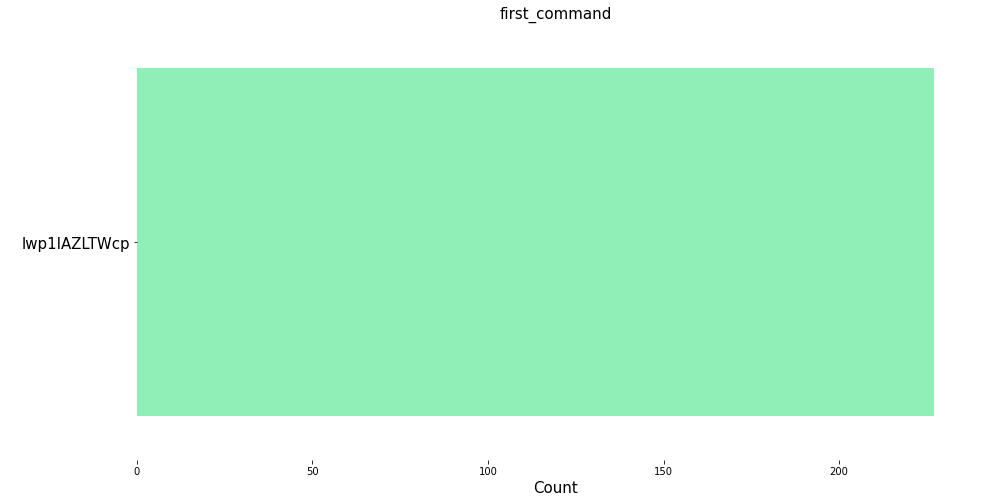

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.countplot(
    y=df["first_command"][1:],
    data=df,
    order=df["first_command"][1:].value_counts().iloc[:].index,
    palette="rainbow",
)
plt.title("first_command", fontsize=15)
plt.xlabel("Count", fontsize=15)
plt.ylabel(" ")
plt.yticks(fontsize=15)
plt.box(False)

In [63]:
df = df_cont[["name", "first_command"]]
df = df[df.name.notnull()]
df["first_command"].fillna("Not Identified", inplace=True)
df = df[df.name.str.contains("sql")]

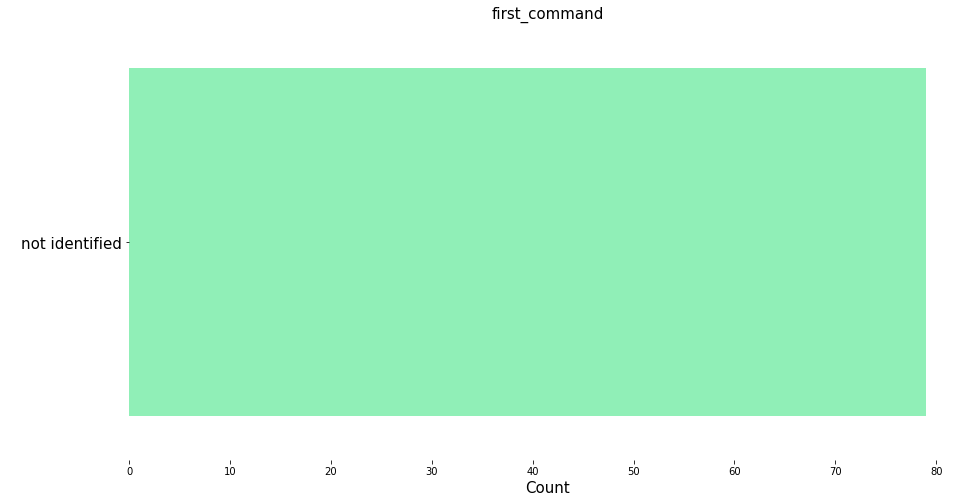

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.countplot(
    y=df["first_command"][1:],
    data=df,
    order=df["first_command"][1:].value_counts().iloc[:].index,
    palette="rainbow",
)
plt.title("first_command", fontsize=15)
plt.xlabel("Count", fontsize=15)
plt.ylabel(" ")
plt.yticks(fontsize=15)
plt.box(False)

---

## Most common RUN command and argument (match with known db of RUN (means first) commands and first arguments)

**Image_layer dataset**

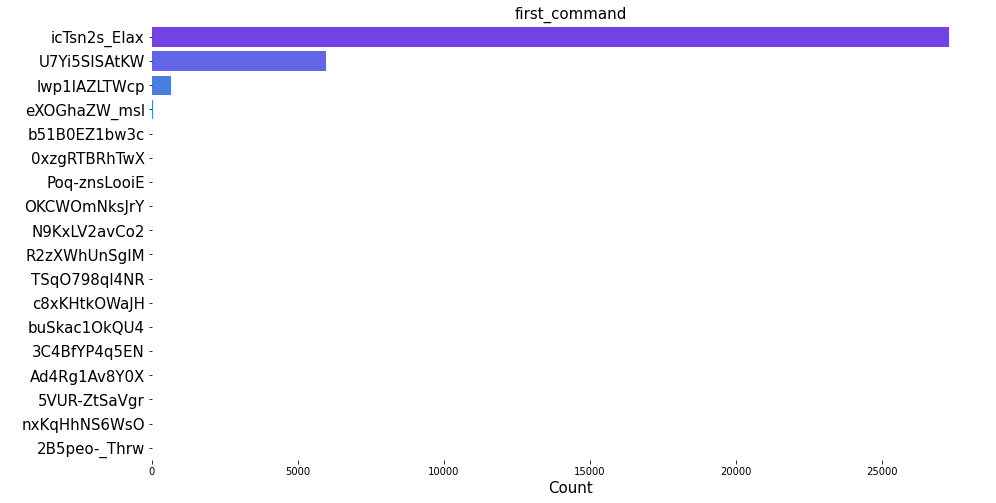

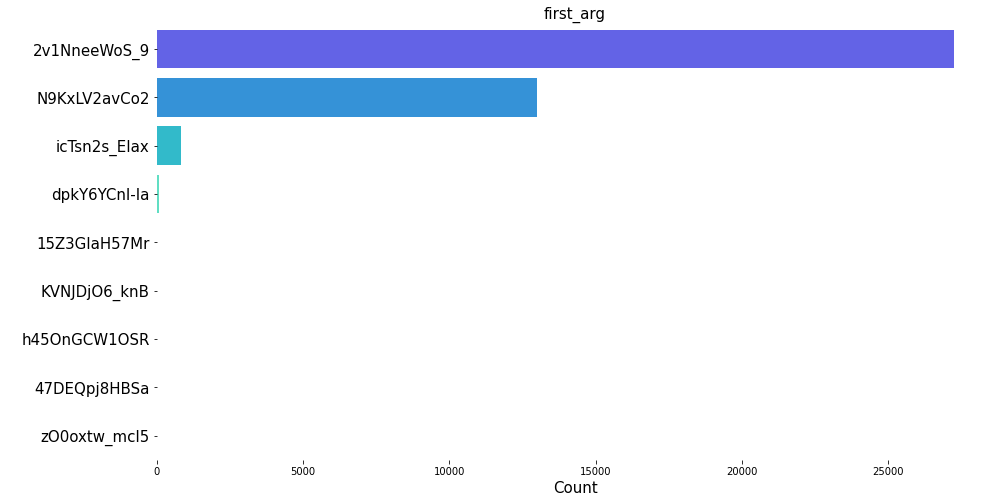

In [21]:
image_columns = ["first_command", "first_arg"]

for col in image_columns:
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    sns.countplot(
        y=df_image[col][1:],
        data=df_image.iloc[1:],
        order=df_image[col][1:].value_counts().iloc[:].index,
        palette="rainbow",
    )
    plt.title(col, fontsize=15)
    plt.xlabel("Count", fontsize=15)
    plt.ylabel(" ")
    plt.yticks(fontsize=15)
    plt.box(False)

**Containers dataset**

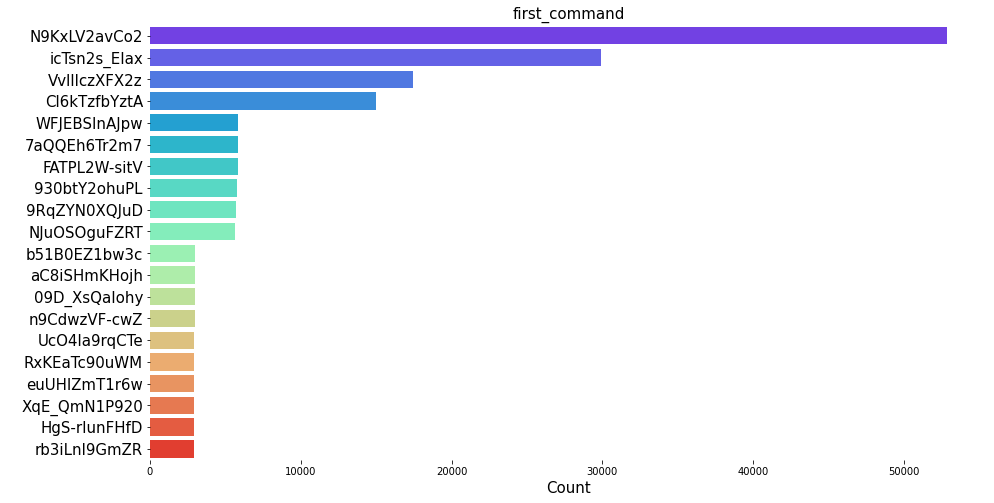

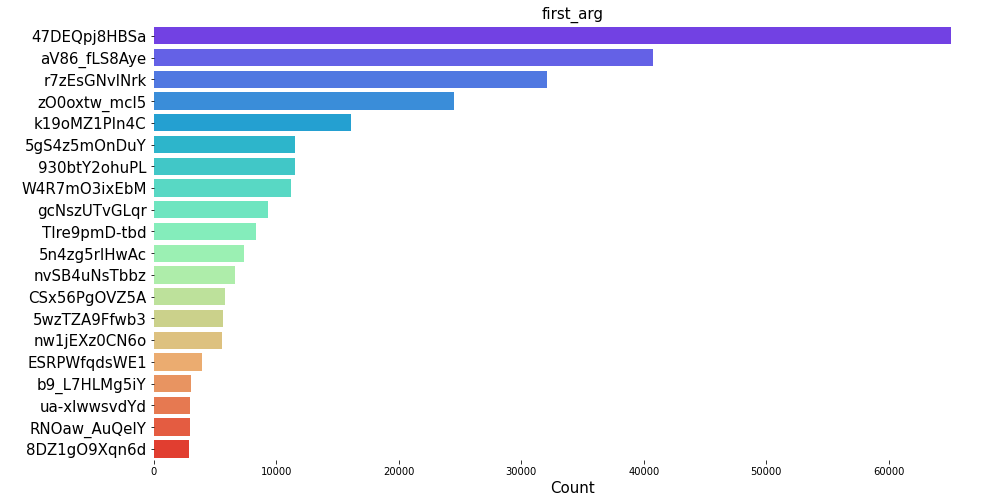

In [22]:
cont_columns = ["first_command", "first_arg"]

for col in cont_columns:
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    sns.countplot(
        y=df_cont[col][1:],
        data=df_cont.iloc[1:],
        order=df_cont[col][1:].value_counts().iloc[:20].index,
        palette="rainbow",
    )
    plt.title(col, fontsize=15)
    plt.xlabel("Count", fontsize=15)
    plt.ylabel(" ")
    plt.yticks(fontsize=15)
    plt.box(False)

---

---

## Top RH/non-RH workloads 

We filter our dataframe depending upon vendor. 

**Image layer dataset**

The different vendor for image_layer dataset are:

In [206]:
df_image.vendor.unique()

array(['Red Hat, Inc.', nan], dtype=object)

We see that `Red Hat, Inc.` is the only vendor name in the dataset. All other are `nan` values. hence, filtering out the dataset based on `Red Hat, Inc.` vendor and plotting the top 20 image repos corresponding to `Red Hat Inc.`, we get the top list of RH workloads,

In [210]:
df = df_image[df_image.vendor == "Red Hat, Inc."]

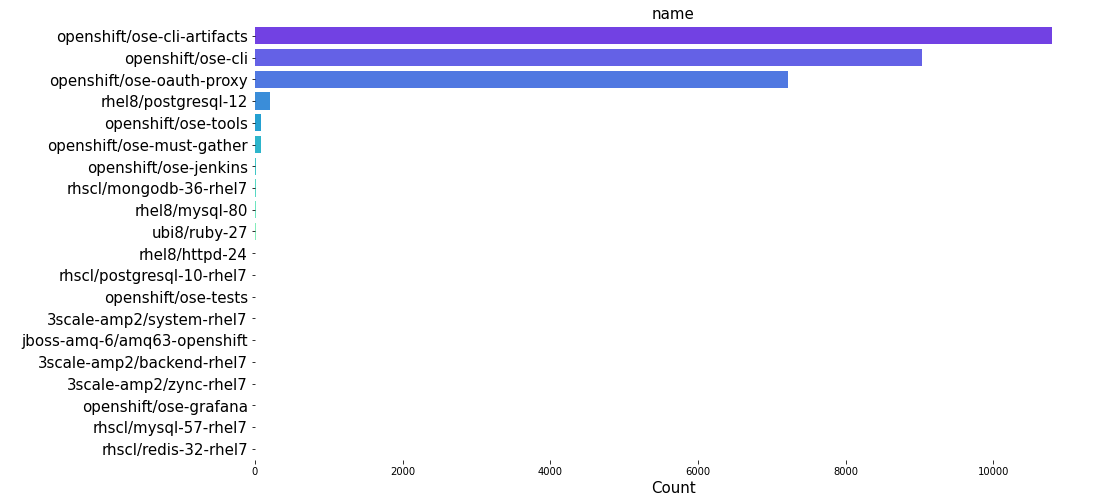

In [211]:
image_columns = ["name"]

for col in image_columns:
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    sns.countplot(
        y=df[col][1:],
        data=df.iloc[1:],
        order=df[col][1:].value_counts().iloc[:20].index,
        palette="rainbow",
    )
    plt.title(col, fontsize=15)
    plt.xlabel("Count", fontsize=15)
    plt.ylabel(" ")
    plt.yticks(fontsize=15)
    plt.box(False)

Now, for non Red Hat workloads, which are `nan` values in the dataset. If we now filter our dataset based on non Red Hat workloads, we get,

In [213]:
df = df_image[df_image.vendor != "Red Hat, Inc."]  # filtered dataframe

Now, checking the list of image_repos for non-RH workload,

In [214]:
df.name.unique()

array([nan], dtype=object)

We see that we do not have the mapped image_repos for non RH workload.

**Container dataset**

Getting the list of vendors in the containers dataset.

In [215]:
df_cont.vendor.unique()

array(['Red Hat, Inc.', nan, 'Seldon Technologies', 'NVIDIA', 'Couchbase',
       'IBM', 'Elastic', 'NGINX Inc <kubernetes@nginx.com>',
       'Project Calico', 'F5 Networks Inc', 'EnterpriseDB Corporation',
       'Microsoft', 'Isovalent', 'Jetstack'], dtype=object)

In [217]:
# filtering the dataset for vendor = Red Hat, Inc.
df = df_cont[df_cont.vendor == "Red Hat, Inc."]

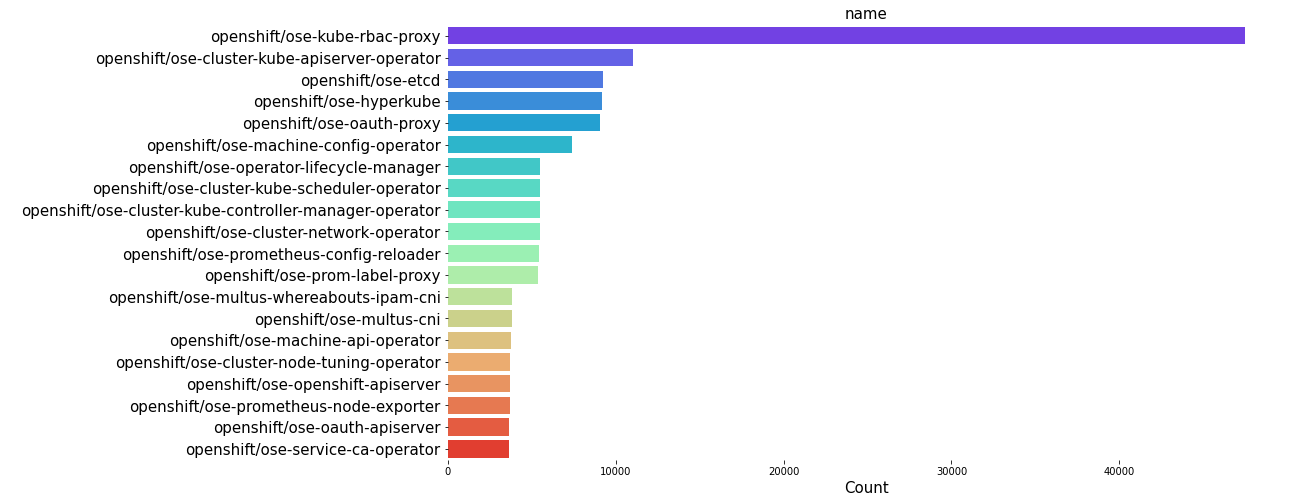

In [218]:
image_columns = ["name"]

for col in image_columns:
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    sns.countplot(
        y=df[col][1:],
        data=df.iloc[1:],
        order=df[col][1:].value_counts().iloc[:20].index,
        palette="rainbow",
    )
    plt.title(col, fontsize=15)
    plt.xlabel("Count", fontsize=15)
    plt.ylabel(" ")
    plt.yticks(fontsize=15)
    plt.box(False)

**Top 20 RH workload**

**Top 20 Non-RH workload**

In [219]:
# filtering the dataset for vendor = Red Hat, Inc.
df = df_cont[df_cont.vendor != "Red Hat, Inc."]

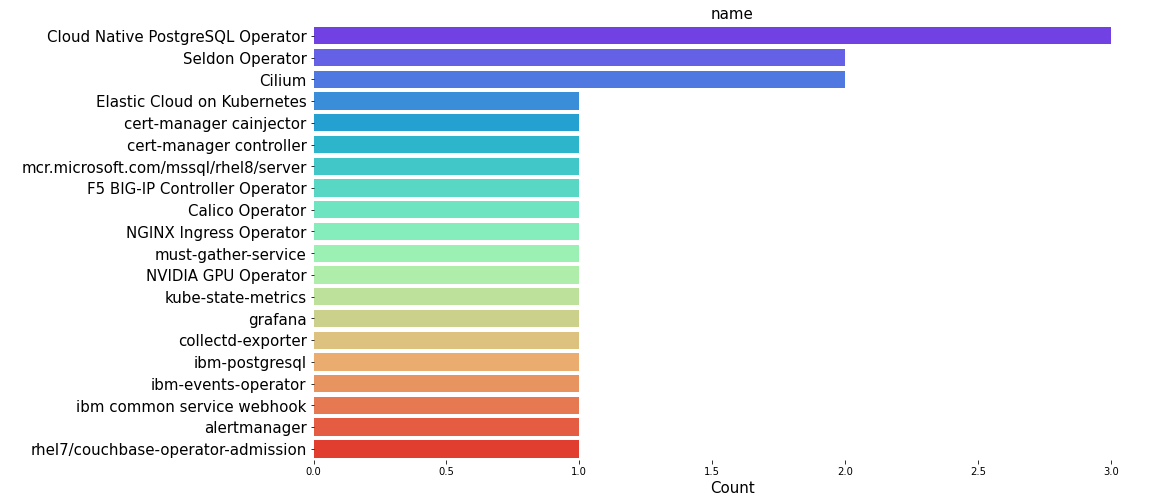

In [220]:
image_columns = ["name"]

for col in image_columns:
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    sns.countplot(
        y=df[col][1:],
        data=df.iloc[1:],
        order=df[col][1:].value_counts().iloc[:20].index,
        palette="rainbow",
    )
    plt.title(col, fontsize=15)
    plt.xlabel("Count", fontsize=15)
    plt.ylabel(" ")
    plt.yticks(fontsize=15)
    plt.box(False)

**Top 20 non-RH workload**

---

## Version distribution for a workload (workloads sorted by product name/namespace w/ versions) - openjdk8 vs. openjdk11

**Version distribution of workloads for image layer dataset**

In [224]:
dfi = df_image.groupby("name")["version"].value_counts().to_frame()
dfi

,,version
name,version,
3scale-amp2/apicast-gateway-rhel8,1.19.0,3
3scale-amp2/backend-rhel7,1.13.0,6
3scale-amp2/memcached-rhel7,1.4.16,3
3scale-amp2/system-rhel7,1.14.0,6
3scale-amp2/zync-rhel7,1.13.0,6
jboss-amq-6/amq63-openshift,1.3,6
openshift/ose-cli,v4.8.0,9030
openshift/ose-cli-artifacts,v4.8.0,10794
openshift/ose-grafana,v4.7.0,5


**Version distribution of workloads for containers dataset**

In [225]:
dfc = df_cont.groupby("name")["version"].value_counts().to_frame()
dfc.head(20)

,,version
name,version,
3scale-amp2/3scale-rhel7-operator,1.13.0,1
3scale-amp2/apicast-gateway-rhel8,1.19.0,3
3scale-amp2/backend-rhel7,1.13.0,5
3scale-amp2/memcached-rhel7,1.4.16,1
3scale-amp2/system-rhel7,1.14.0,7
3scale-amp2/zync-rhel7,1.13.0,3
Calico Operator,v1.7.3,1
Cilium,v1.9.5,2
Cloud Native PostgreSQL Operator,1.1.0,3


---

## Comparison of workloads & versions - how many quarkus vs. java containers/layers 

In [165]:
dfc = dfc.reset_index()

In [166]:
dfc.head()

,name,version,frequency
0,3scale-amp2/3scale-rhel7-operator,1.13.0,1
1,3scale-amp2/apicast-gateway-rhel8,1.19.0,3
2,3scale-amp2/backend-rhel7,1.13.0,5
3,3scale-amp2/memcached-rhel7,1.4.16,1
4,3scale-amp2/system-rhel7,1.14.0,7


In [169]:
dfc = dfc[dfc.name.str.contains("java")]

In [170]:
dfc

,name,version,frequency


---

## Quarkus used as a base image/layer vs. bundled (Comparison of workload vs. a common RUN command from an unknown image)


In [171]:
df_image1 = df_image[["layer_image_id", "layer_image_level"]]
image_layer_idmap = image_layer_idmap[["layer_image_id", "name"]]

df_layer = pd.merge(df_image1, image_layer_idmap, on="layer_image_id", how="inner")
df_layer.groupby("layer_image_level").name.value_counts().to_frame()

name
layer_image_level name                                            
0                 Watson Assistant CLU Sire GRPC Server          2
                  hdm/common-zookeeper                           1
                  redislabs/k8s-controller                       1
1                 ubi8                                        2406
                  ubi7                                          21
                  rhel7                                         10
                  ubi8-minimal                                   4
2                 ubi8/s2i-core                                 94
                  rhscl/s2i-core-rhel7                          27
                  dotnet/dotnet-31-runtime-rhel7                 5
                  ubi8/dotnet-50-runtime                         3
                  openjdk/openjdk-11-rhel7                       2
                  3scale-amp2/apicast-gateway-rhel8              1
                  3scale-amp2/memcached-rhel7                    1
                  dotnet/dotnet-30-runtime-rhel7                 1
                  jboss-eap-7/eap73-openjdk8-openshift-rhel7     1
                  redhat-openjdk-18/openjdk18-openshift          1
                  rhel8/buildah                                  1
                  ubi8/dotnet-31-runtime                         1
3                 rhel8/postgresql-12                           50
                  ubi8/s2i-base                                 27
                  rhscl/s2i-base-rhel7                          13
                  ubi8/nodejs-14                                 7
                  dotnet/dotnet-31-rhel7                         5
                  rhel8/httpd-24                                 4
                  rhscl/nodejs-14-rhel7                          4
                  rhel8/mysql-80                                 3
                  rhscl/mongodb-36-rhel7                         3
                  ubi8/dotnet-50                                 3
                  openshift/ose-oauth-proxy                      2
                  rhscl/nginx-118-rhel7                          2
                  rhscl/postgresql-10-rhel7                      2
                  dotnet/dotnet-30-rhel7                         1
                  fuse7/fuse-karaf-openshift                     1
                  rhel8/postgresql-10                            1
                  rhel8/redis-5                                  1
                  rhscl/httpd-24-rhel7                           1
                  rhscl/mysql-57-rhel7                           1
                  rhscl/redis-32-rhel7                           1
                  ubi8/dotnet-31                                 1
                  ubi8/nginx-118                                 1
4                 ubi8/nodejs-12                                10
                  ubi8/php-73                                    6
                  rhscl/python-36-rhel7                          4
                  rhscl/ruby-25-rhel7                            3
                  ubi8/ruby-26                                   3
                  rhscl/perl-530-rhel7                           2
                  rhscl/ruby-27-rhel7                            2
                  ubi8/php-74                                    2
                  ubi8/ruby-27                                   2
                  openshift/ose-grafana                          1
                  rhel8/go-toolset                               1
                  rhscl/php-72-rhel7                             1
                  rhscl/python-38-rhel7                          1
                  ubi8/perl-526                                  1
                  ubi8/perl-530                                  1
                  ubi8/python-38                                 1
5                 3scale-amp2/backend-rhel7                      1
                  3scale-amp2/system-rhel7

---

# Conclusion

The following notebook serves the purpose of addressing some of the queries listed in this [link](https://docs.google.com/document/d/1-3q0Ow_a5IzsrWm7k1hc3YmIzoW_k7Xyf40Qp4wICAI/edit#heading=h.z3syrddb94ke) Here we perform EDA on insight operator workload dataset.

---